In [109]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [110]:
(x_trn, y_trn), (x_tst, y_tst) = mnist.load_data()

In [111]:
num_classes = 10
num_features = 28 * 28
lr = 0.01
epochs = 100
batch_size = 32

In [112]:
x_train = np.array(x_trn, np.float32).reshape([-1, num_features]) / 255.
x_test = np.array(x_tst, np.float32).reshape([-1, num_features]) / 255.

y_train = tf.one_hot(y_trn, depth=num_classes)
y_test = tf.one_hot(y_tst, depth=num_classes)

In [113]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [114]:
all_losses = []
all_accuracy = []
all_epochs = []

In [115]:
n_hidden_1 = 64
n_hidden_2 = 24

In [116]:
class Model(object):
    def __init__(self):
        rnd_norm = tf.initializers.RandomNormal()
        self.W1 = tf.Variable(rnd_norm([num_features, n_hidden_1]))
        self.W2 = tf.Variable(rnd_norm([n_hidden_1, n_hidden_2]))
        self.Wout = tf.Variable(rnd_norm([n_hidden_2, num_classes]))
        self.B1 = tf.Variable(tf.zeros([n_hidden_1]))
        self.B2 = tf.Variable(tf.zeros([n_hidden_2]))
        self.Bout = tf.Variable(tf.zeros([num_classes]))


    def forward(self, x):
        self.layer1 = tf.nn.sigmoid(tf.add(tf.matmul(x, self.W1), self.B1))
        self.layer2 = tf.nn.sigmoid(tf.add(tf.matmul(self.layer1, self.W2), self.B2))
        self.output = tf.nn.softmax(tf.add(tf.matmul(self.layer2, self.Wout), self.Bout))
        return self.output

In [117]:
def loss(y_pred, y_target):
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_target * tf.math.log(y_pred)))
    return cross_entropy

In [118]:
def accuracy(y_pred, y_target):
    correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_target, 1))
    acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return acc

In [119]:
model = Model()
optimizer = tf.optimizers.SGD(lr)

In [120]:
def optimization(x, y):
    with tf.GradientTape() as gt:
        cur_loss = loss(model.forward(x), y)

    trainable_variables = [model.W1, model.W2, model.Wout, model.B1, model.B2, model.Bout]
    grad = gt.gradient(cur_loss, trainable_variables)
    optimizer.apply_gradients(zip(grad, trainable_variables))

In [121]:
def train(epochs):
    for epoch, (batch_x, batch_y) in enumerate(train_data.take(epochs), 1):
        optimization(batch_x, batch_y)
        if(epoch % 100 == 0):
            pred = model.forward(batch_x)
            loss_r = loss(pred, batch_y)
            acc_r = accuracy(pred, batch_y)
            all_losses.append(loss_r)
            all_accuracy.append(acc_r)
            all_epochs.append(epoch)
            print("Epoch {0} Loss is {1} Accuracy is {2}".format(epoch, loss_r, acc_r))
    
    return model

In [122]:
model = train(1000)

Epoch 100 Loss is 71.91143798828125 Accuracy is 0.1875
Epoch 200 Loss is 70.90463256835938 Accuracy is 0.21875
Epoch 300 Loss is 66.58729553222656 Accuracy is 0.4375
Epoch 400 Loss is 44.704376220703125 Accuracy is 0.59375
Epoch 500 Loss is 34.404014587402344 Accuracy is 0.59375
Epoch 600 Loss is 22.966320037841797 Accuracy is 0.8125
Epoch 700 Loss is 25.962318420410156 Accuracy is 0.75
Epoch 800 Loss is 19.74106216430664 Accuracy is 0.8125
Epoch 900 Loss is 18.48767852783203 Accuracy is 0.875
Epoch 1000 Loss is 14.586477279663086 Accuracy is 0.9375


In [123]:
pred_val = model.forward(x_test)
print("Test accuracy is %f" % accuracy(pred_val, y_test))

Test accuracy is 0.821000


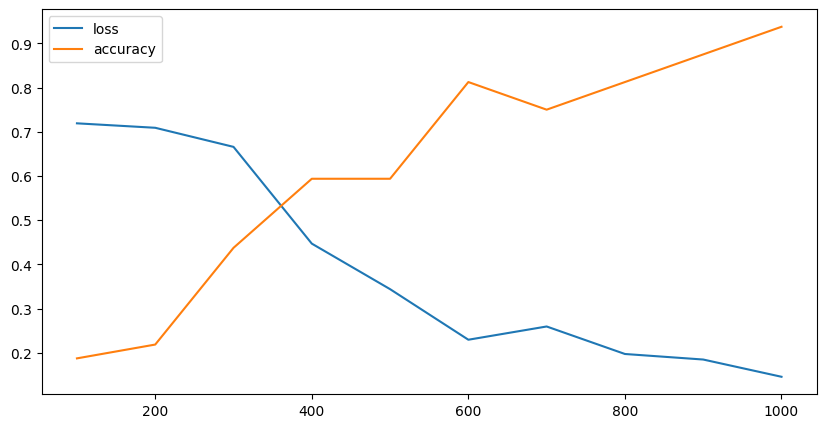

In [124]:
all_losses = np.array(all_losses) / 100.0

fig, axs = plt.subplots(figsize = (10, 5))
plt.plot(all_epochs, all_losses, label = "loss")
plt.plot(all_epochs, all_accuracy, label = "accuracy")
plt.legend()
plt.show()